In [1]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = './coin'
train_x_df = pd.read_csv(f'{data_path}/train_x_df.csv')
train_y_df = pd.read_csv(f'{data_path}/train_y_df.csv')
test_x_df = pd.read_csv(f'{data_path}/test_x_df.csv')

In [3]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [4]:
def to_3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [5]:
train_x_array = to_3d(train_x_df)
train_y_array = to_3d(train_y_df)
test_x_array = to_3d(test_x_df)

In [6]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [7]:
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series) + len(y_series)),
            y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

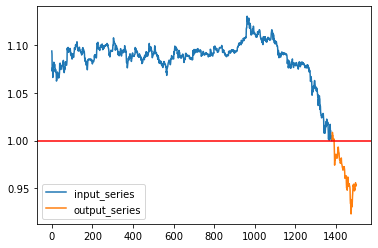

In [8]:
idx = 1012
plot_series(train_x_array[idx, :, 1], train_y_array[idx, :, 1])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

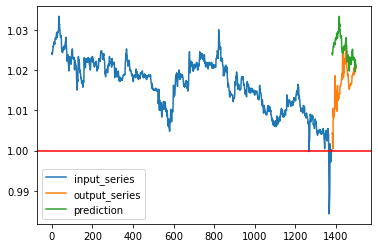

In [11]:
idx = 1121
x_series = train_x_array[idx, :, 1]
y_series = train_y_array[idx, :, 1]

model = ARIMA(x_series, order = (3, 0, 1))
fit = model.fit()
preds = fit.predict(1, 120, typ = 'levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380 + 120), preds, label = 'prediction')
plt.legend()
plt.show

In [14]:
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [16]:
def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [58]:
my_auto_arima(x_series, [5,5,5])

,order,AIC
27,p1 d0 q2,-12838.824225
74,p3 d0 q0,-12838.539822
28,p1 d0 q3,-12837.216547
52,p2 d0 q2,-12837.073082
99,p4 d0 q0,-12836.688398
...,...,...
45,p1 d4 q0,-10016.861651
2,p0 d0 q2,-9819.298560
20,p0 d4 q0,-8864.703124
1,p0 d0 q1,-8598.864692


<function matplotlib.pyplot.show(close=None, block=None)>

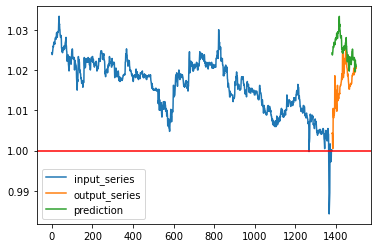

In [18]:
idx = 1121

model = ARIMA(x_series, order = (1, 0, 1))
fit = model.fit()
preds = fit.predict(1, 120, typ = 'levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380 + 120), preds, label = 'prediction')
plt.legend()
plt.show

In [20]:
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = to_3d(valid_x_df)
valid_y_array = to_3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

In [59]:
for idx in tqdm(range(valid_x_array.shape[0])):
    x_series = valid_x_array[idx,:,1]

    model = ARIMA(x_series, order=(1,0,2))
    fit  = model.fit()
    preds = fit.predict(1,120, typ='levels')
    valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [03:08<00:00,  1.59it/s]


In [21]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

 27%|█████████████████████▊                                                           | 81/300 [00:40<01:45,  2.07it/s]

order 4 1 1


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [02:11<00:18,  2.03it/s]

order 4 1 1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:30<00:00,  1.99it/s]


In [60]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [61]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [62]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,0,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
295,295,0,35
296,296,0,1
297,297,1,19
298,298,0,25


In [63]:
valid_submission.buy_quantity.value_counts()

0    291
1      9
Name: buy_quantity, dtype: int64

In [64]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [65]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [66]:
print(total_momey)

10025.382269829428


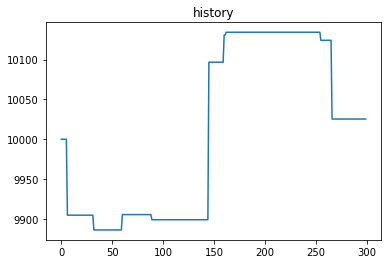

In [67]:
plt.plot(total_momey_list)
plt.title("history")
plt.show()

In [68]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    x_series = test_x_array[idx,:,1]

    model = ARIMA(x_series, order=(1,0,2))
    fit  = model.fit()
    preds = fit.predict(1,120, typ='levels')
    test_pred_array[idx,:] = preds
    

100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [04:50<00:00,  1.82it/s]


In [69]:
submission = array_to_submission(test_x_array, test_pred_array)

In [70]:
submission.to_csv("baseline_submission.csv", index = False)